# FINAL investigation of quiescent parts of light curves
- possible path forward: look for every quiescent chunk in LC
    - or at least compare to starting from end, but first probably easier to adapt from current code
- not currently adding to table but can run again and write out table (probably with better column names) to do so
- previous case seemed convincing that periodicities don't disappear, but can repeat in this context (for sufficiently long baselines)
# RESULTS
- a few sources *do* have sig stdev ratios that place them in type 7 region
    - would just mention that vast majority aren't in that region but e.g. 126 and 19, 40
        - no dippers? just type 1-like
        - a couple type 5 but not as convincing/not for awhile
    - so type 7s *may* leave that region but not as likely as the type 6s

In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

# summ = pd.read_csv('summtab.csv')
alls = pd.read_csv('allsummtab.csv')

cross['Part'] = 1
cross2 = Table.read('part2files.csv')
cross2 = join(cross2,full,keys='src_n')
cross2['Part'] = 2

In [2]:
mlist2 = ['OII I','OIII I','OIV I']
mlist1 = ['OII I','OIII I']
def plot(s):
    try: iband, vband = o.getIV(s,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
    except: iband, vband = o.getIV(s,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))
def sf(name):
    plt.savefig(f'Figs/{name}.png',dpi=150,bbox_inches='tight')

In [3]:
#change with finalized table
type6 = o.gettype(alls,num='6')
type7 = o.gettype(alls,num='7')

Text(0.5, 0, 'det I stdev/overall I stdev')

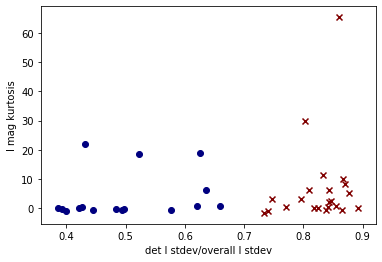

In [4]:
#using these names since used for plotting; but legends display final names
for t in type6:
    row = alls[alls['src_n']==t]
    plt.scatter(row['sig stdev ratio'],row['I kurtosis'],color='navy')
#     plt.text(row['det stdev I']/row['I range'],row['I kurtosis'],str(int(row['src_n'])))
for t in type7:
    row = alls[alls['src_n']==t]
    plt.scatter(row['sig stdev ratio'],row['I kurtosis'],color='maroon',marker='x')
#     plt.text(row['det stdev I']/row['stdev I'],row['I kurtosis'],str(int(row['src_n'])))
plt.ylabel('I mag kurtosis')
plt.xlabel('det I stdev/overall I stdev')

## code to find chunks of quiescence
- start with example

In [49]:
def sigdetrend(iband):
    '''check if this was final way of getting sig stdev ratio: rather than sig, based on mag of 1 from mean'''
    flatten,trend = o.splinedetrend(iband,retspline=True)
    mean = np.mean(iband['I mag'])
    detimag = iband['I mag'] - trend + mean
    detimag[np.abs(detimag-mean)>1] = mean
    ostd = np.nanstd(iband['I mag'])
    det_std = np.nanstd(detimag)    
    return det_std/ostd

In [57]:
def findratio(iband,start,leng=500):
    #get chunk of some length
    chunk = iband[iband['MJD-50000']>start]
    chunk = chunk[chunk['MJD-50000']<start+leng]
    #detrend chunk
    try:ratio = sigdetrend(chunk)
    except: ratio = np.nan #e.g. if max error from spline detrend pops up
    return ratio

In [45]:
#rewrite to first find start of quiescence
def findqui(iband,leng=500,step=50,src=0,plotlc=False,retratio=False,minq=500,c=1,maxiter=3):
    '''leng: length of chunk to check for ratio
    step: stepsize to next chunk (step<leng)'''
    #get iband if src>0
    if src>0:
        try:iband = o.getIV(src,cross,stack=True,both=False)
        except:iband = o.getIV(src,cross2,mlist=mlist2,stack=True,both=False)
    start = iband['MJD-50000'][0]
    end = iband['MJD-50000'][-1]
    qui = False
    ctime = start
    while not qui and ctime<end:
        ratio = findratio(iband,ctime,leng=leng)
        if ratio>.35: #based on minimum of type 5
            qui = True #start of quiescence
            qstart = ctime
        else: ctime+=leng
    #if never starts ~quiescence
    if not qui and retratio: return np.nan,np.nan,np.nan,np.nan
    elif not qui: return np.nan,np.nan
    ctime = qstart #repetitive?
    while qui and ctime<end:
        ratio1 = findratio(iband,ctime,leng=leng)
        #also check using whole quiescent part thus far
        ratio2 = findratio(iband,qstart,leng=ctime-qstart+leng)
        if ratio1<.35 or ratio2<.35: 
            qui=False #not quiescent
        else: ctime+=step
    if plotlc:
        if src>0:plot(src)
        else: 
            plt.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=4)
            if c==1: plt.ylim(np.max(iband['I mag'])+.1,np.min(iband['I mag'])-.1)
        plt.axvspan(qstart,ctime,alpha=0.1)
    #run again
    if ctime-qstart<minq:
        while ctime-qstart<minq and c<maxiter: #iterate a couple times more at most, or stop when quiescent part longer
            c+=1
            print(f'iterating again for src {src}...')
            #call function again but increased c (counter)
            #and pass in iband with shortened iband
            short = iband[iband['MJD-50000']>ctime]
            qstart,ctime = findqui(short,leng=leng,step=step,src=0,plotlc=plotlc,retratio=False,minq=minq,c=c)
#             if c==maxiter or ctime-qstart>=minq: retratio=True
    if retratio: #also return stdev ratio and kurtosis
        if ctime-qstart<minq:return qstart,ctime,np.nan,np.nan
        qchunk = iband[iband['MJD-50000']>=qstart]
        qchunk = qchunk[qchunk['MJD-50000']<=ctime]
        #detrend
        try:
            ratio = sigdetrend(qchunk)
        except: ratio = np.nan
        return qstart,ctime,ratio,st.kurtosis(qchunk['I mag'])
    return qstart,ctime #start and end times of quiescence

In [46]:
acopy = alls.copy()
acopy['qdur'] = [np.nan]*len(acopy)
acopy['ratio'] = [np.nan]*len(acopy)
acopy['kurt'] = [np.nan]*len(acopy)

In [78]:
#doing in chunks to make plot inspection easier
def sources(start=0,end=20):
    for s in alls['src_n'][start:end]:
        row = acopy[acopy['src_n']==s]
        if int(s) in type6 or int(s) in type7: #but called type 5 and 6 on plots
            #automatically set to duration and to ratio and kurtosis already in table
            try:iband = o.getIV(s,cross,both=False,stack=True)
            except:iband = o.getIV(s,cross2,mlist=mlist2,both=False,stack=True)
            end = float(iband['MJD-50000'][-1])
            start = float(iband['MJD-50000'][0])
            kurt = row['I kurtosis']
            ratio = row['sig stdev ratio']
        else:
            start,end,ratio,kurt = findqui([],src=s,plotlc=True,retratio=True)
        row['qdur'] = end-start
        row['ratio'] = ratio
        row['kurt'] = kurt
        acopy[acopy['src_n']==s] = row

In [79]:
findqui([],src=2,retratio=True)

(2590.92954, 3090.92954, 0.3538353875695294, 0.05791859124573495)

iterating again for src 4...
iterating again for src 6...
iterating again for src 7...
iterating again for src 9...
iterating again for src 11...
iterating again for src 0...
iterating again for src 13...
iterating again for src 0...
iterating again for src 14...
iterating again for src 15...
iterating again for src 0...
iterating again for src 15...
iterating again for src 17...
iterating again for src 0...
iterating again for src 17...


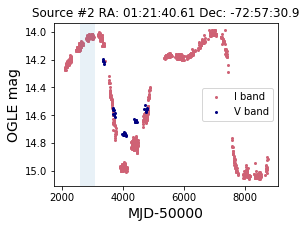

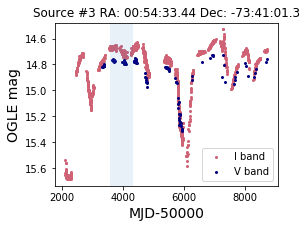

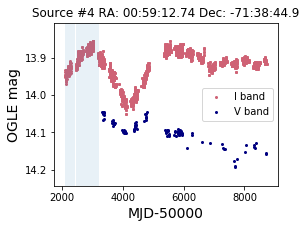

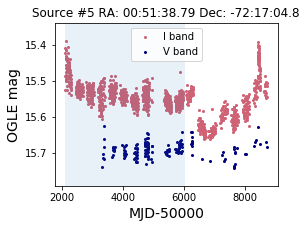

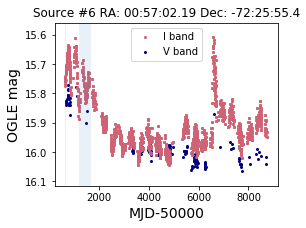

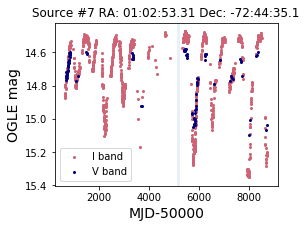

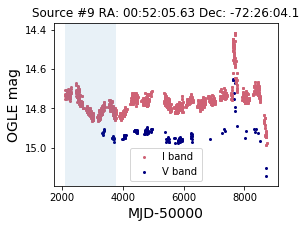

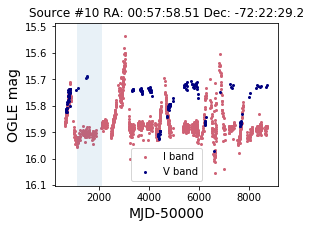

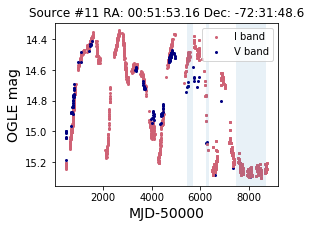

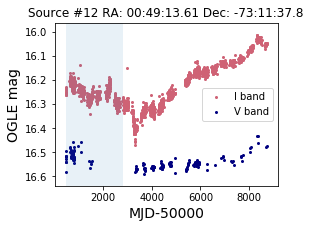

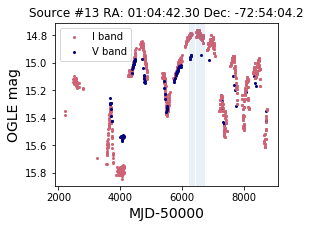

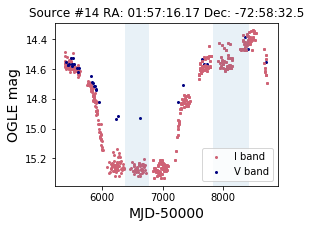

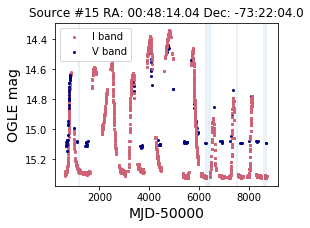

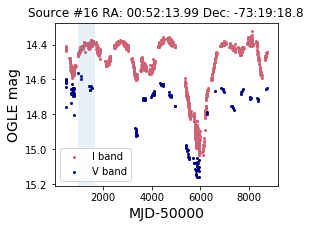

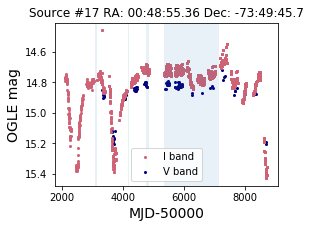

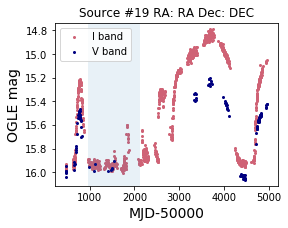

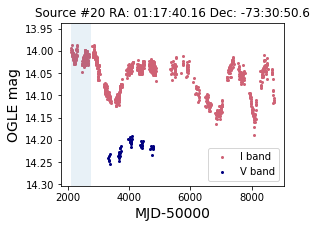

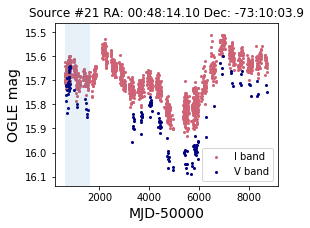

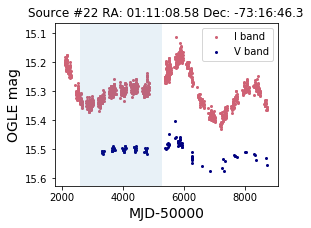

In [80]:
sources()

iterating again for src 23...
iterating again for src 0...
iterating again for src 24...
iterating again for src 0...
iterating again for src 24...
empty file for OIII I
iterating again for src 27...
iterating again for src 0...
iterating again for src 27...
iterating again for src 32...
iterating again for src 37...


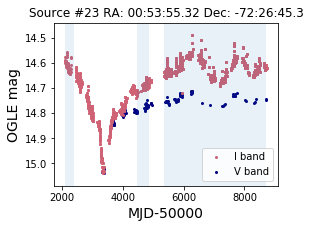

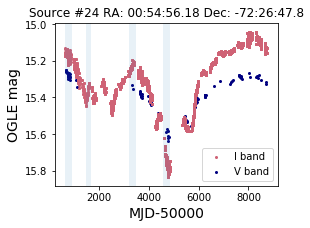

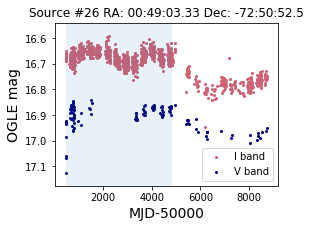

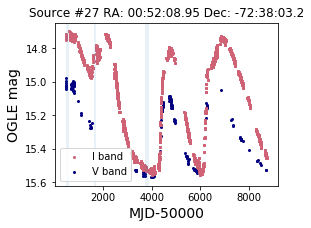

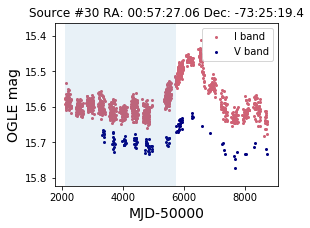

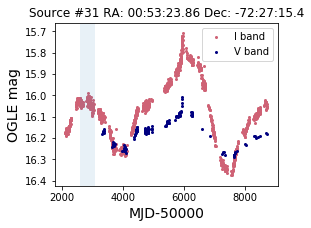

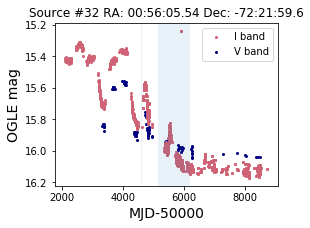

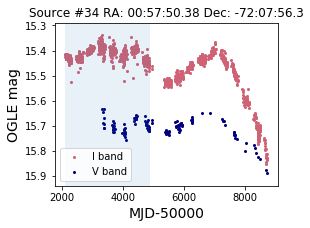

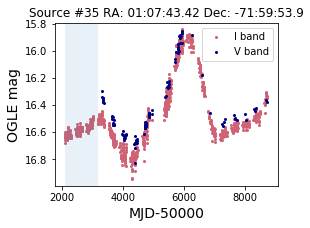

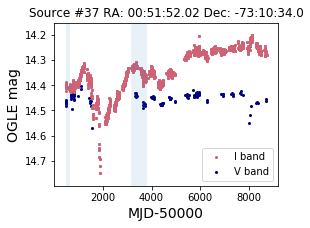

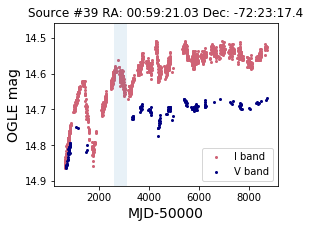

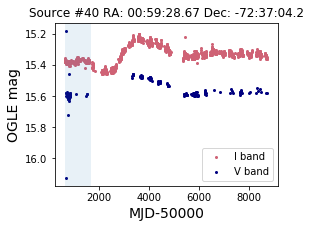

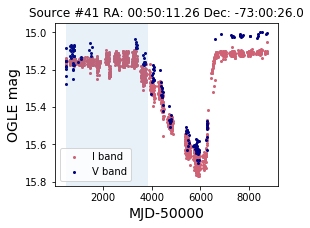

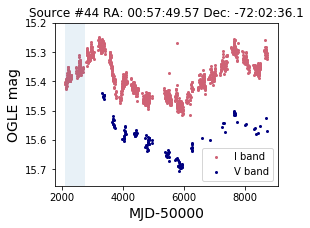

In [81]:
sources(start=20,end=40) #plots messed up with axis limits but doesn't matter for now

iterating again for src 48...
iterating again for src 0...
iterating again for src 48...


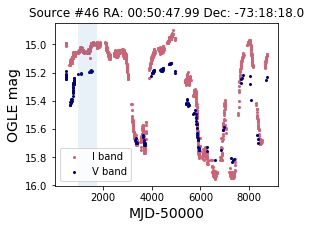

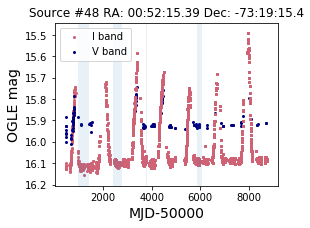

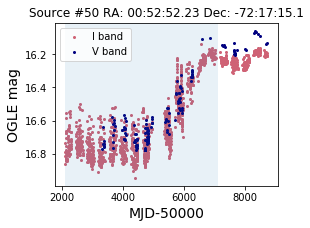

In [82]:
sources(start=40,end=45)

iterating again for src 52...
iterating again for src 0...
iterating again for src 52...
iterating again for src 57...
iterating again for src 0...
iterating again for src 57...
iterating again for src 62...
iterating again for src 0...
iterating again for src 62...
iterating again for src 63...
iterating again for src 0...


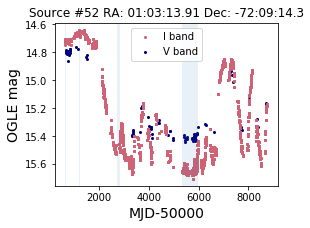

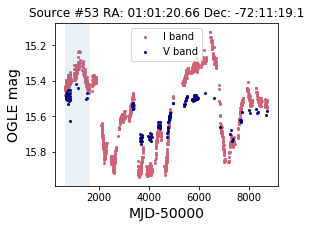

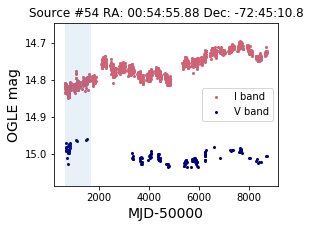

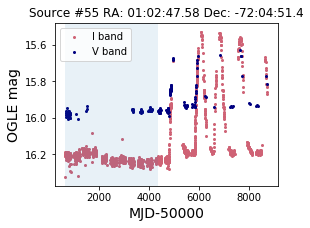

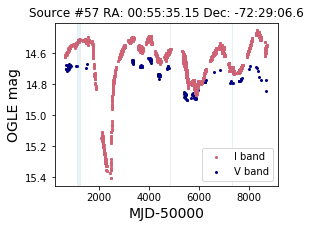

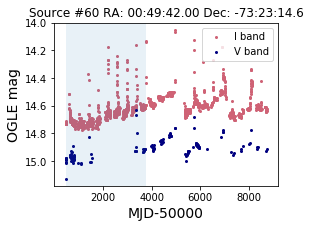

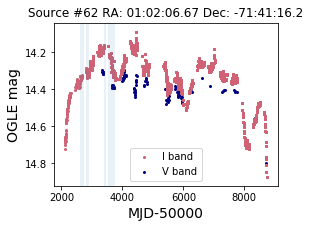

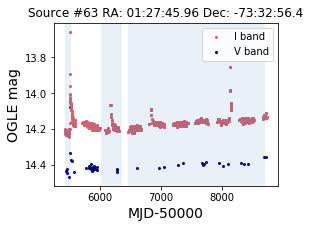

In [83]:
sources(start=46,end=60)

iterating again for src 67...
iterating again for src 0...
iterating again for src 73...
iterating again for src 0...
empty file for OII I
iterating again for src 80...
iterating again for src 86...
iterating again for src 0...
iterating again for src 86...
iterating again for src 87...
iterating again for src 95...


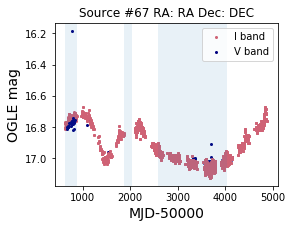

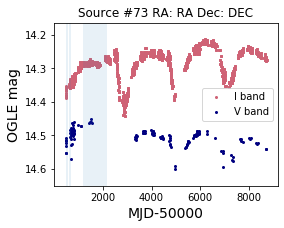

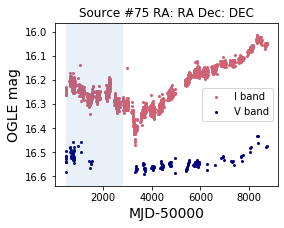

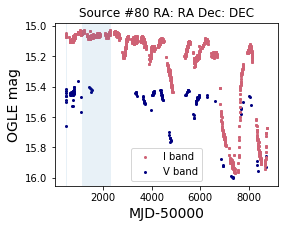

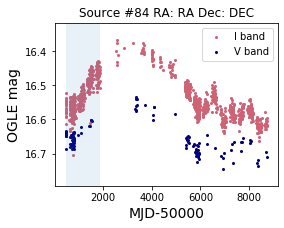

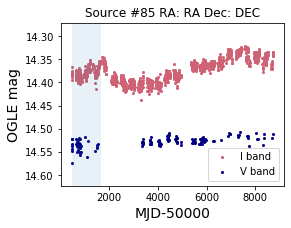

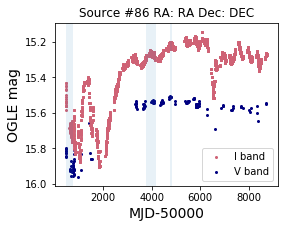

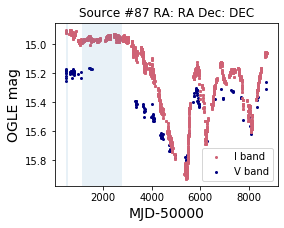

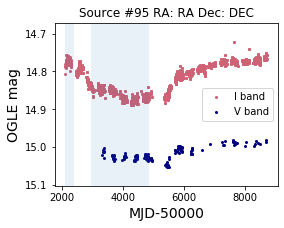

In [84]:
sources(start=60,end=80) #may need to calibrate or use other ratio for type 6, 7

iterating again for src 97...
iterating again for src 104...
iterating again for src 0...
iterating again for src 104...
empty file for OIII I
empty file for OIII I
iterating again for src 116...
iterating again for src 0...
iterating again for src 116...
iterating again for src 123...
iterating again for src 0...
iterating again for src 124...
iterating again for src 125...
iterating again for src 0...
iterating again for src 128...
iterating again for src 0...
iterating again for src 128...


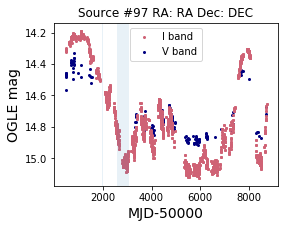

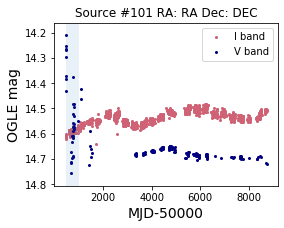

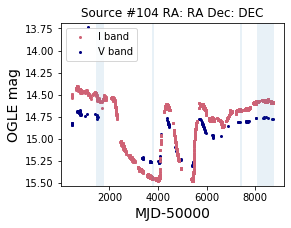

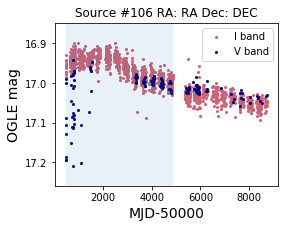

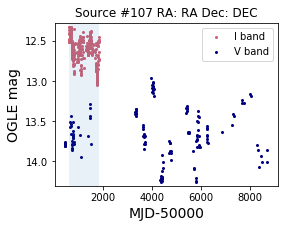

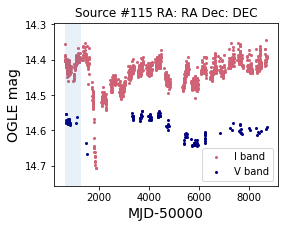

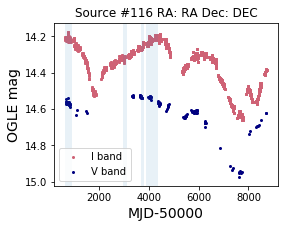

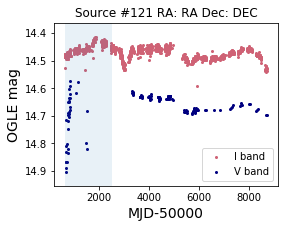

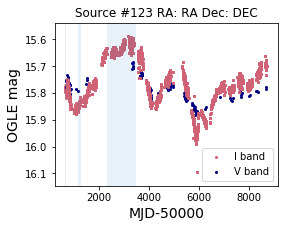

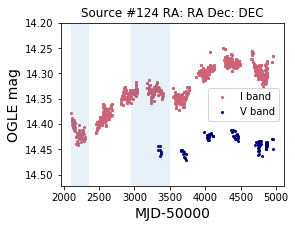

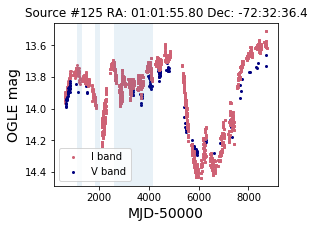

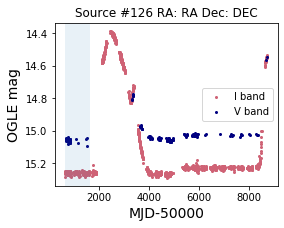

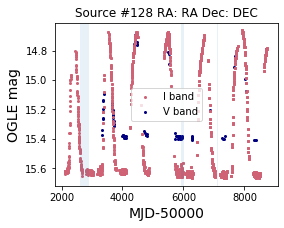

In [85]:
sources(start=80,end=100)

iterating again for src 132...
iterating again for src 0...
iterating again for src 132...
iterating again for src 136...


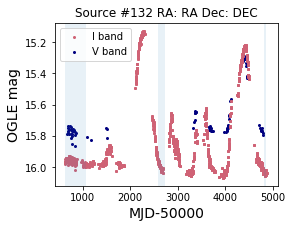

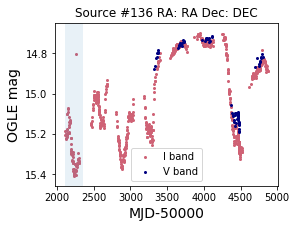

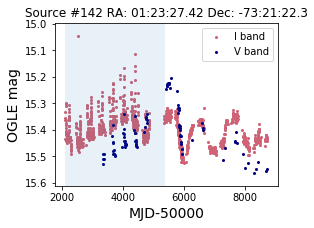

In [86]:
sources(start=100,end=108)

In [61]:
acopy[:10]['ratio']

0    0.353835
1    0.422975
2    0.166482
3    0.338290
4    0.166969
5         NaN
6    0.850132
7    0.229158
8    0.203583
9    0.675799
Name: ratio, dtype: float64

### need to iterate in case it finds quiescent region that is shorter than another in LC


In [92]:
long = acopy[acopy['qdur']>1000]

In [12]:
typet = []
for i in range(len(alls)):
    row = alls.iloc[i]
    src = row['src_n']
    if '+' in str(row['type']):
        typet.append(int(src))

In [95]:
typet

[11, 19, 27, 32, 50, 52, 97]

In [7]:
type1 = o.gettype(alls,num='1')
type2 = o.gettype(alls,num='2')
type3 = o.gettype(alls,num='3')
type4 = [60,63]
type5 = o.gettype(alls,num='5')+[5, 6, 9, 10]
type6 = o.gettype(alls,num='6')
type7 = o.gettype(alls,num='7')

In [9]:
def fulltplot(x='stdev I',y='det stdev I',legend=True,tbool=[False]*6,between=False,tab=alls):
    if between and len(tbool)==6: tbool.append(False) #make sure tbool is right length 
    o.tplot(type1,tab,color=pink,marker='*',label='1',x=x,y=y,text=tbool[0])
    o.tplot(type2,tab,color='black',label='2',x=x,y=y,text=tbool[1])
    o.tplot(type3,tab,color='black',marker='o',x=x,y=y,text=tbool[1],label='')
    o.tplot(type5,tab,marker='v',label='3',color='maroon',x=x,y=y,text=tbool[2])
    o.tplot(type4,tab,color='rebeccapurple',marker='P',label='4',x=x,y=y,text=tbool[3])
    if between: o.tplot(typet,tab,marker='p',label='transition',color='navy',x=x,y=y,text=tbool[6])
    if x=='ratio':x='sig stdev ratio' #overwrite b/c of calibration issue
    if y=='ratio':y='sig stdev ratio'
    o.tplot(type6,tab,marker='3',label='5',color='grey',x=x,y=y,text=tbool[4])
    o.tplot(type7,tab,color='darkseagreen',marker='h',label='6',x=x,y=y,text=False)
    #if between, also plot transition sources
    plt.ylabel(y,fontsize=14)
    plt.xlabel(x,fontsize=14)
    if legend: plt.legend()

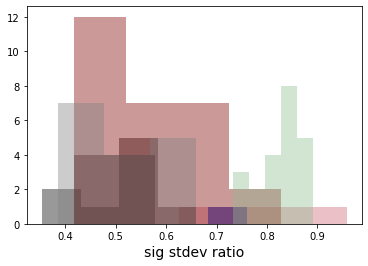

In [176]:
#histograms but too many
fulltplot(tab=acopy,x='ratio',y='',legend=False)

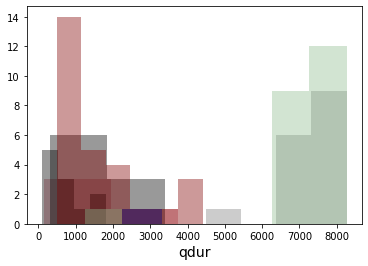

In [177]:
fulltplot(tab=acopy,x='qdur',y='',legend=False)

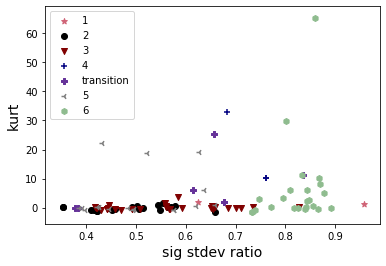

In [98]:
fulltplot(tab=acopy,x='ratio',y='kurt',between=True)

In [123]:
[False]*6+[True]

[False, False, False, False, False, False, True]

In [166]:
a = acopy[acopy['ratio']>.7]#cutoff for type 6
b = a[a['type']!='7']
print(np.array(b['src_n']),np.array(b['qdur']))
print(np.array(b['type']))

[ 19  31  40  60 124 126 142] [1150.  500. 1050. 3300.  550. 1000. 3300.]
['1+5' '5' '5' '4' '5' '1' nan]


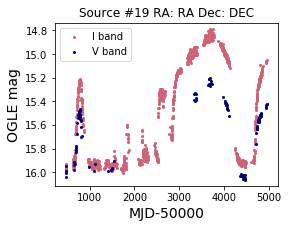

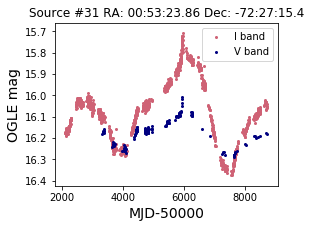

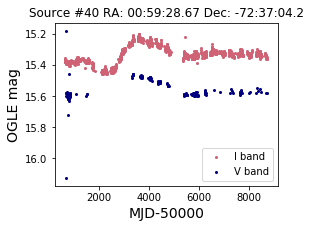

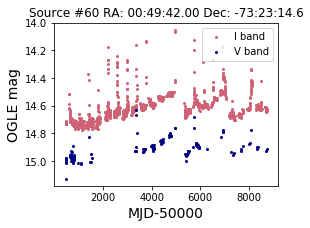

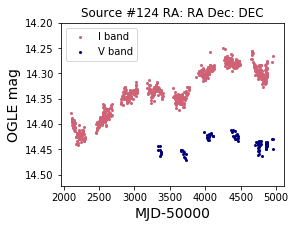

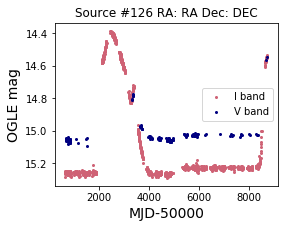

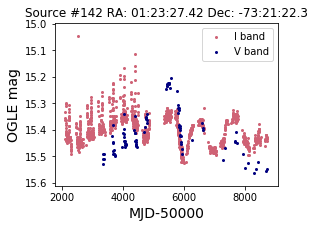

In [158]:
#sources with quiescent part in type 7 region
#ones with over 1000 days: 19,40,60,126,(142)
for s in b['src_n']:
    plot(s)

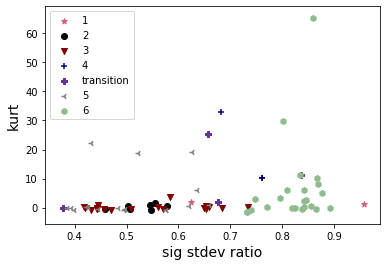

In [145]:
#if we use minimum 1000 days of quiescence
reload(o)
fulltplot(tab=long,x='ratio',y='kurt',between=True)

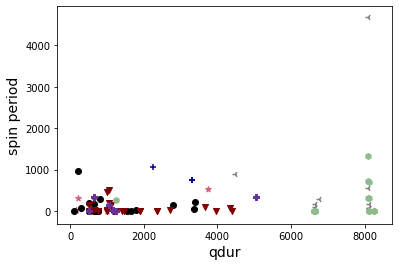

In [104]:
#now repeating same plots from above
fulltplot(tab=acopy,x='qdur',y='spin period',between=True,legend=False)
# plt.xscale('log')
# plt.yscale('log')
# plt.ylim(-1000,8000)

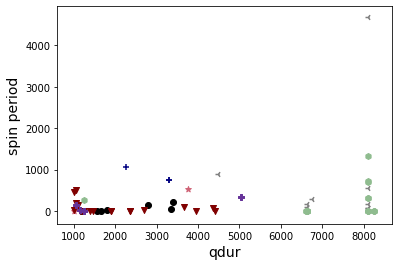

In [111]:
fulltplot(tab=long,x='qdur',y='spin period',between=True,legend=False)

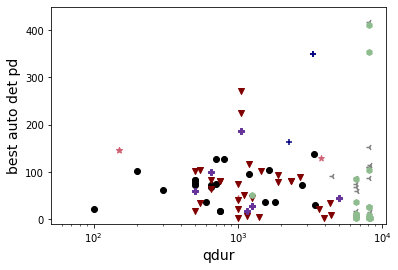

In [105]:
#500 day not 1000 day cutoff
fulltplot(tab=acopy,x='qdur',y='best auto det pd',between=True,legend=False)
plt.ylim(-10,450)
plt.xscale('log')

In [110]:
#min 1000 days
# fulltplot(tab=long,x='qdur',y='best auto det pd',between=True,legend=False)
# plt.ylim(-10,450)
# plt.xscale('log')